In [1]:
import numpy as np
import pandas as pd
import os
import six

import matplotlib.pyplot as plt
plt.style.use("default")
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# Création des fonctions
def get_dataframe(path, n_breeds=12):
    dogs_lst = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            dogs_lst.append(os.path.join(dirname, filename))

    # Je stocke dans un dataframe
    dogs_raw = pd.DataFrame(dogs_lst, columns=['uri'])

    # J'extrais la race
    dogs_raw['breeds'] = dogs_raw.uri.str.split('/').str.get(5).str.slice(10)
    
    # Délimitation du nombre de race
    top_breeds = dogs_raw.groupby('breeds').count().sort_values(by='uri', ascending=False).head(n_breeds).reset_index().breeds.to_list()
    dogs = pd.DataFrame()
    for b in top_breeds:
        dogs = dogs.append(dogs_raw[dogs_raw.breeds == b])

    return dogs


def split_and_generate_dataframe(df, px):
    seed = 42

    # Séparation des données d'entrainements et de tests
    train, test = train_test_split(df, test_size=0.2, random_state=seed)
    # Séparation des données d'entrainements et de validation
    train, val = train_test_split(train, test_size=0.2, random_state=seed)

    ### Paramétrage
    x = 'uri'
    y = 'breeds'

    train_batch_size = get_batch_size(len(train))
    val_batch_size = get_batch_size(len(val))
    test_batch_size = get_batch_size(len(test))

    train_datagen = ImageDataGenerator(rescale=1./255)
    train_datagen_aug = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
    val_test_datagen = ImageDataGenerator(rescale=1./255)

    # Sans augmentation des données
    train_gen = train_datagen.flow_from_dataframe(
                      train,
                      x_col='uri',
                      y_col='breeds',
                      target_size=(px, px),
                      batch_size=train_batch_size,
                      seed=seed
                      )


    # Avec augmentation des données
    train_gen_data_aug = train_datagen_aug.flow_from_dataframe(
                              train,
                              x_col='uri',
                              y_col='breeds',
                              target_size=(px, px),
                              batch_size=train_batch_size,
                              seed=seed
                              )

    val_gen = val_test_datagen.flow_from_dataframe(
                      val,
                      x_col = x,
                      y_col = y,
                      target_size=(px, px),
                      batch_size=val_batch_size,
                      seed=seed
                      )

    test_gen = val_test_datagen.flow_from_dataframe(
                      test,
                      x_col = x,
                      y_col = y,
                      target_size=(px, px),
                      batch_size=test_batch_size,
                      seed=seed,
                      shuffle=False
                      )

    return [train_gen, train_gen_data_aug, val_gen, test_gen]

def get_batch_size(gen):
    lst = []
    dict = {}
    
    # Test des nombres entiers et intégration dans un dictionnaire
    for i in range(1,40):
        dict[i] = gen % i
    
    # Récupération du plus grand nombre entiers
    for key, value in dict.items():
        if value == 0:
            lst.append(key)

    return max(lst)


def get_model(act_function):
    model = Sequential()
    ### Couches de convolutions
    # Couche 1
    model.add(Conv2D(32, (3, 3), activation=act_function, input_shape=(256, 256, 3)))
    model.add(MaxPooling2D((2, 2)))

    # Couche 2
    model.add(Conv2D(64, (3, 3), activation=act_function))
    model.add(MaxPooling2D((2, 2)))

    # Couche 3
    model.add(Conv2D(128, (3, 3), activation=act_function))
    model.add(MaxPooling2D((2, 2)))
    
    # Couche 4
    model.add(Conv2D(128, (3, 3), activation=act_function))
    model.add(MaxPooling2D((2, 2)))
    
    # Couche 5
    model.add(Conv2D(128, (3, 3), activation=act_function))
    model.add(MaxPooling2D((2, 2)))


    return model


def plot_activation_functions(history, subtitle):
    # Extraction des historique
    val_loss = {k:v.history['val_loss'] for k,v in activation_results.items()}
    val_acc = {k:v.history['val_accuracy'] for k,v in activation_results.items()}
    # Conversion en df
    val_loss_curves = pd.DataFrame(val_loss)
    val_acc_curves = pd.DataFrame(val_acc)
    # Graphique
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

    ax[0].plot(val_loss_curves.relu, label='relu')
    ax[0].plot(val_loss_curves.sigmoid, label='sigmoid')
    ax[0].plot(val_loss_curves.tanh, label='tanh')
    ax[0].set_title('val_loss | ' + subtitle + ' | Activation Function')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Val_loss')
    ax[0].legend()

    ax[1].plot(val_acc_curves.relu, label='relu')
    ax[1].plot(val_acc_curves.sigmoid, label='sigmoid')
    ax[1].plot(val_acc_curves.tanh, label='tanh')
    ax[1].set_title('val_accuracy | ' + subtitle + ' | Activation Function')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('val_accuracy')
    ax[1].legend()

    plt.savefig('./cnn_transfer_learning_' + subtitle + '_activation_function.png',
                    transparent=True)
    return None


def plot_optimizer(history, subtitle):
    # Extraction des historique
    val_loss = {k:v.history['val_loss'] for k,v in opt_results.items()}
    val_acc = {k:v.history['val_accuracy'] for k,v in opt_results.items()}
    # Conversion en df
    val_loss_curves = pd.DataFrame(val_loss)
    val_acc_curves = pd.DataFrame(val_acc)
    # Graphique
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

    ax[0].plot(val_loss_curves.adam, label='adam')
    ax[0].plot(val_loss_curves.RMSProp, label='RMSProp')
    ax[0].plot(val_loss_curves.SGD, label='SGD')
    ax[0].set_title('val_loss | ' + subtitle + ' | Optimizers')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Val_loss')
    ax[0].legend()

    ax[1].plot(val_acc_curves.adam, label='adam')
    ax[1].plot(val_acc_curves.RMSProp, label='RMSProp')
    ax[1].plot(val_acc_curves.SGD, label='SGD')
    ax[1].set_title('val_accuracy | ' + subtitle + ' | Optimizers')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('val_accuracy')
    ax[1].legend()

    plt.savefig('./cnn_transfer_learning_' + subtitle + '_optimizers.png',
                    transparent=True)
    return None


def plot_effect(history_std, history_modified, title, subtitle):
    # Conversion en dataframe
    df_model_std = pd.DataFrame(history_std.history['val_accuracy'], columns=["model_std"])
    df_model_modified = pd.DataFrame(history_modified.history['val_accuracy'], columns=[title])

    # Tracage
    pd.merge(df_model_std, df_model_modified, right_index=True, left_index=True).plot()
    plt.title(title + "_" + subtitle)
    plt.xlabel("epoch")
    plt.ylabel("val_accuracy")
    plt.savefig('./cnn_transfer_learning_ ' + subtitle + '_' + title + '.png',
                transparent=True)
    plt.show()
    return None


def plot_result_fitting(history, model, title, n_breeds):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

    ax[0].plot(history.history['accuracy'], label='accuracy')
    ax[0].plot(history.history['val_accuracy'], label = 'val_accuracy')
    ax[0].set_title('Accuracy | ' + model + ' | ' + title + ' | ' + str(n_breeds) + ' breeds')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='loss')
    ax[1].plot(history.history['val_loss'], label = 'val_loss')
    ax[1].set_title('Loss function | ' + model + ' | ' + title + ' | ' + str(n_breeds) + ' breeds')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.savefig('./cnn_transfer_learning_' + model + '_' + title + '_' + str(n_breeds) + '_breeds_results.png',
                transparent=True)
    plt.show()
    return None


def plot_confusion_matrix(model, title, n_breeds):
    pred = model.predict_classes(test_gen)
    cf_matrix = confusion_matrix(test_gen.classes, pred)
    sns.heatmap(cf_matrix, cmap='Purples')
    plt.title('Matrice de confusion | ' + title + ' | ' + str(n_breeds) + ' breeds')
    plt.axis('off')
    plt.savefig('./cnn_transfer_learning_' + title + '_' + str(n_breeds) + '_breeds_confusion_matrix.png',
                transparent=True)
    plt.show()
    return

def export_png_table(data, col_width=2.2, row_height=0.625, font_size=10,
                     header_color='#7451eb', row_colors=['#f1f1f2', 'w'],
                     edge_color='w', bbox=[0, 0, 1, 1], header_columns=1,
                     ax=None, filename='table.png', **kwargs):
    ax = None
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])
                ) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox,
                         colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0] % len(row_colors)])

    fig.savefig(filename, transparent=True)

    return None

---
# 1. Limitation des données | Charge 10 % (12 races)

L'expérimentation se fait en 3 étapes :
* Mesure des effets des fonctions d'activations,
* Formation d'un modèle naif servant de baseline,
* Mesure de l'effet de BatchNormalization(),
* Mesure de l'effet de DropOut(),

Les résultats sur les données des tests sont comparés. Les sorties d'entraînements accuracy et loss sont analysés afin de détecter un éventuel surapprentissage.

Une phase d'expérimentation se fera sur 40 epochs. En fin de notebook, la fin sera réglé par un EarlyStopping.

In [3]:
# Paramètrage des données d'entrées
n_breeds = 12
dogs = get_dataframe('../input/stanford-dogs-dataset/images', n_breeds)
print(f"Nous avons {dogs.breeds.nunique()} races sélectionnées pour la phase d'expérimentation.")

# Création des générateurs
train_gen, train_gen_data_aug, val_gen, test_gen = split_and_generate_dataframe(dogs, 256)

subtitle = "CNN_from_scratch"

Nous avons 12 races sélectionnées pour la phase d'expérimentation.
Found 1694 validated image filenames belonging to 12 classes.
Found 1694 validated image filenames belonging to 12 classes.
Found 424 validated image filenames belonging to 12 classes.
Found 530 validated image filenames belonging to 12 classes.


---
# 2. Mesures des effets des fonctions d'activations

Test de la fonction d'activation relu en cours ...
Test de la fonction d'activation sigmoid en cours ...
Test de la fonction d'activation tanh en cours ...


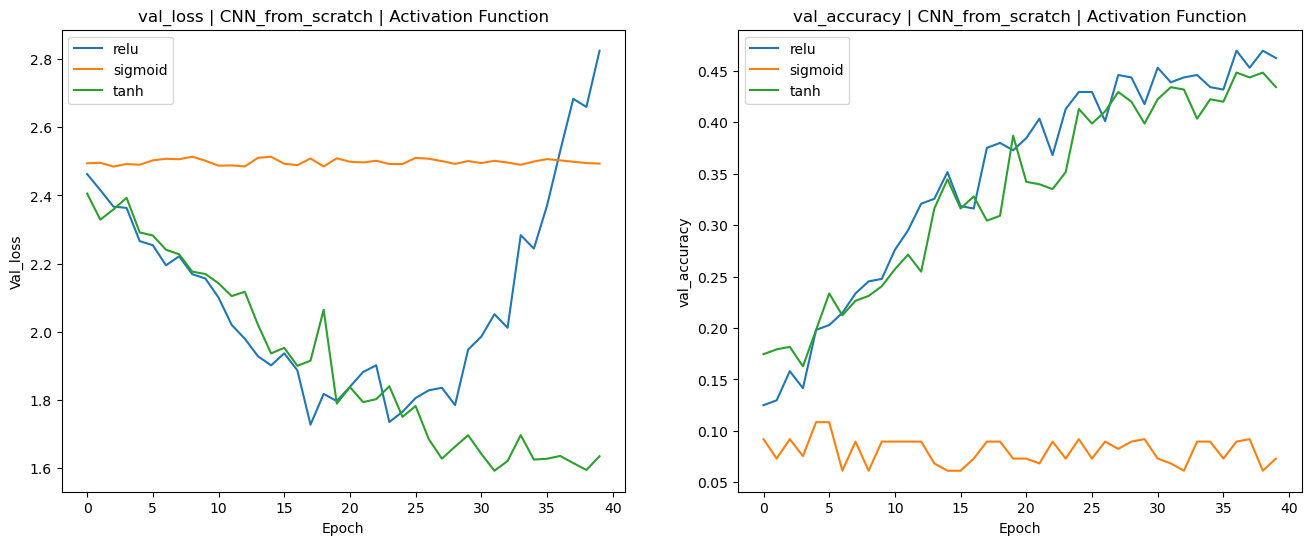

In [4]:
activations = ['relu', 'sigmoid', 'tanh']
activation_results = {}

for funct in activations:
    print(f"Test de la fonction d'activation {funct} en cours ...")
    model = get_model(act_function=funct)
    
    ### Couches de Classification
    # Applatissement (transform to vector 1D)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(len(train_gen.class_indices), activation='softmax'))
    
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    history = model.fit(train_gen, validation_data=val_gen, epochs=40, verbose=0)
    activation_results[funct] = history

plot_activation_functions(history, subtitle)

La fonction d'activation relu présente les meilleurs résultats, elle sera conservé pour la suite de l'étude.

---
# 3. Mesures des effets des optimiseurs

Test de l'optimiseur adam en cours ...
Test de l'optimiseur RMSProp en cours ...
Test de l'optimiseur SGD en cours ...


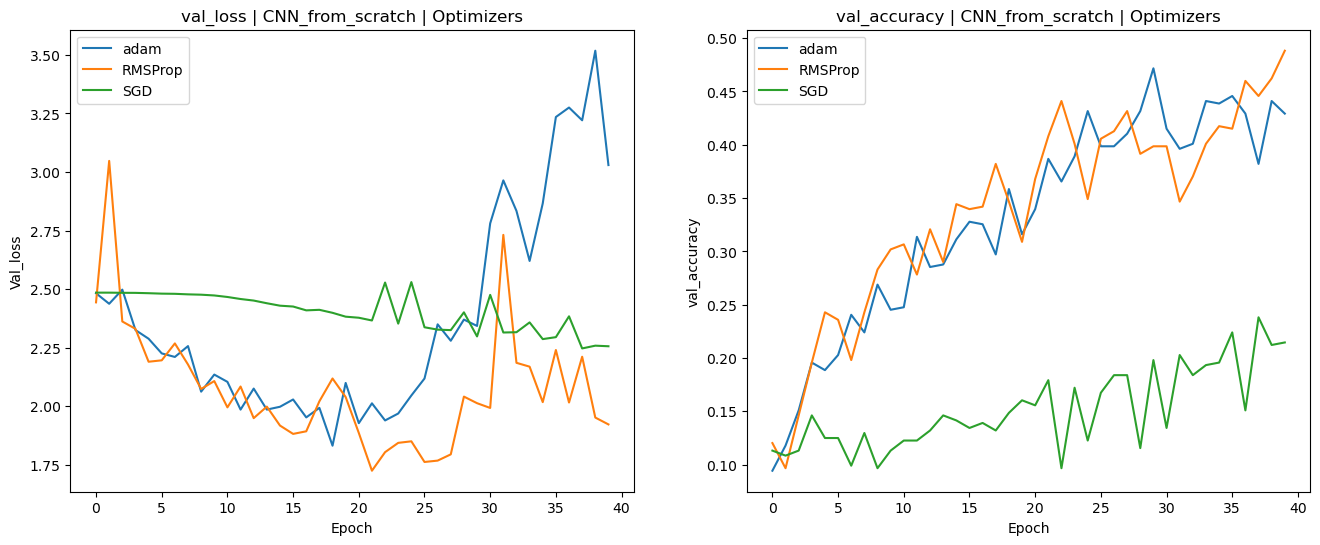

In [5]:
optimizers = ['adam', 'RMSProp', 'SGD']
opt_results = {}

for opt in optimizers:
    print(f"Test de l'optimiseur {opt} en cours ...")
    model = get_model(act_function='relu')
    
    ### Couches de Classification
    model.add(GlobalAveragePooling2D())
    model.add(Dense(len(train_gen.class_indices), activation='softmax'))
    
    model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    history = model.fit(train_gen, validation_data=val_gen, epochs=40, verbose=0)
    opt_results[opt] = history

plot_optimizer(history, subtitle)

---
# 4. Mesures de quelques tests
## 4-1. Modèle standard lancé "naïvement"

In [6]:
epochs = 40
verbose = 0
act = 'relu'
opt = 'adam'

test_accuracy = {}

53/53 [==============================] - 4s 68ms/step - loss: 3.2958 - accuracy: 0.4377


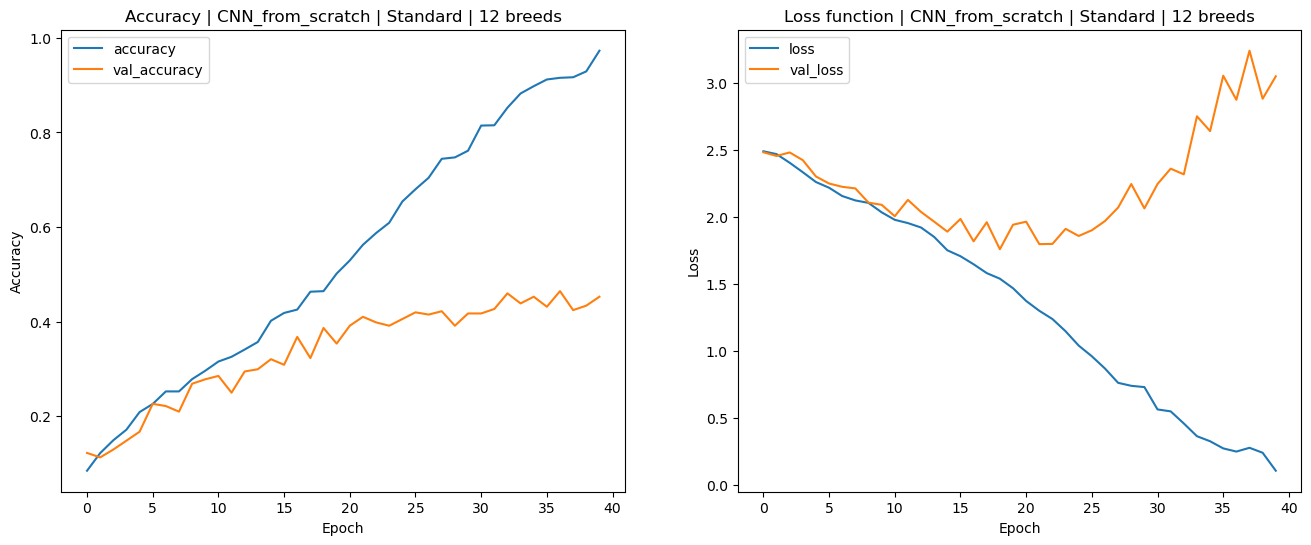

In [7]:
model_std = get_model(act_function=act)
### Couches de Classification
# Applatissement (transform to vector 1D)
model_std.add(GlobalAveragePooling2D())
model_std.add(Dense(len(train_gen.class_indices), activation='softmax'))

model_std.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

history_std = model_std.fit(train_gen, validation_data=val_gen, epochs=epochs, verbose=verbose)

title = "Standard"
test_accuracy[title] = model_std.evaluate(test_gen)[1]
plot_result_fitting(history_std, subtitle, title, n_breeds)

## 4-2. Mesure de l'effet de Flatten() ou GlobalAveragePooling2D()

53/53 [==============================] - 3s 48ms/step - loss: 11.8893 - accuracy: 0.3189


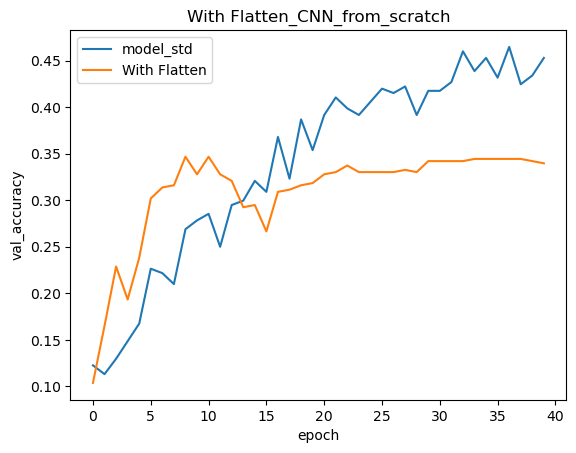

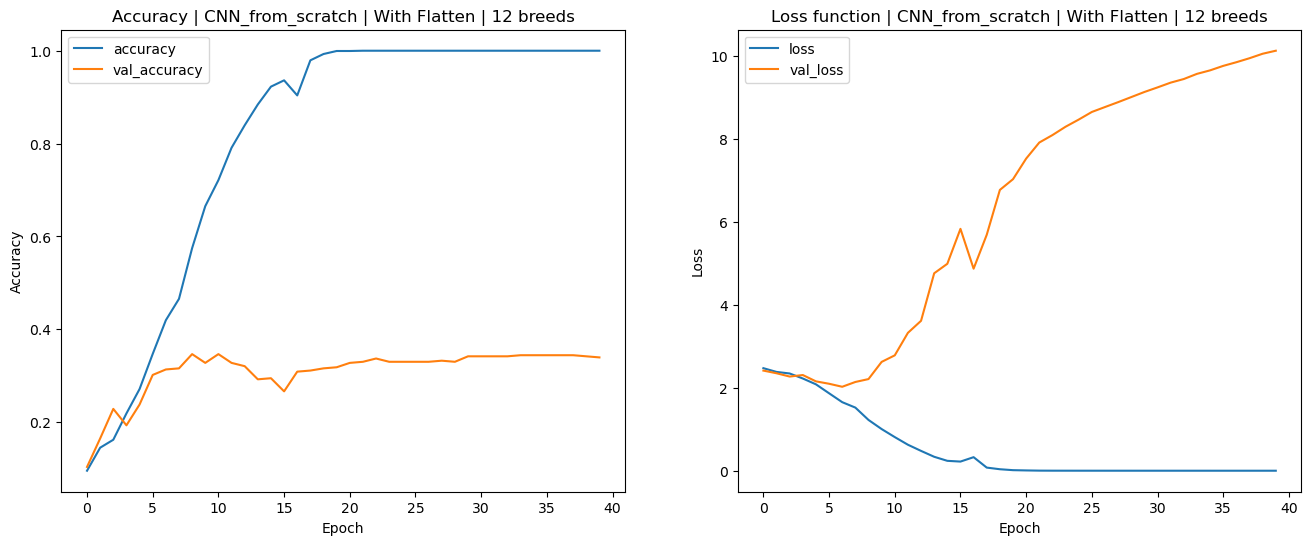

In [8]:
model_flatten = get_model(act_function=act)
### Couches de Classification
# Applatissement (transform to vector 1D)
model_flatten.add(Flatten())
model_flatten.add(Dense(len(train_gen.class_indices), activation='softmax'))

model_flatten.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

history_flatten = model_flatten.fit(train_gen, validation_data=val_gen, epochs=epochs, verbose=verbose)


title = "With Flatten"
test_accuracy[title] = model_flatten.evaluate(test_gen)[1]
plot_effect(history_std, history_flatten, title, subtitle)
plot_result_fitting(history_flatten, subtitle, title, n_breeds)

## 4-3. Mesure de l'effet d'une couche dense supplémentaire

53/53 [==============================] - 3s 49ms/step - loss: 3.0350 - accuracy: 0.4981


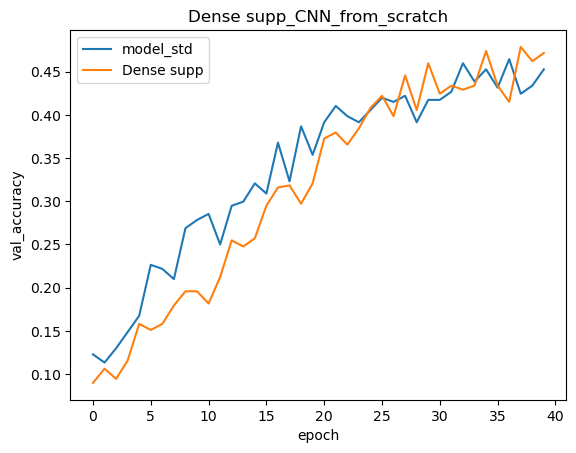

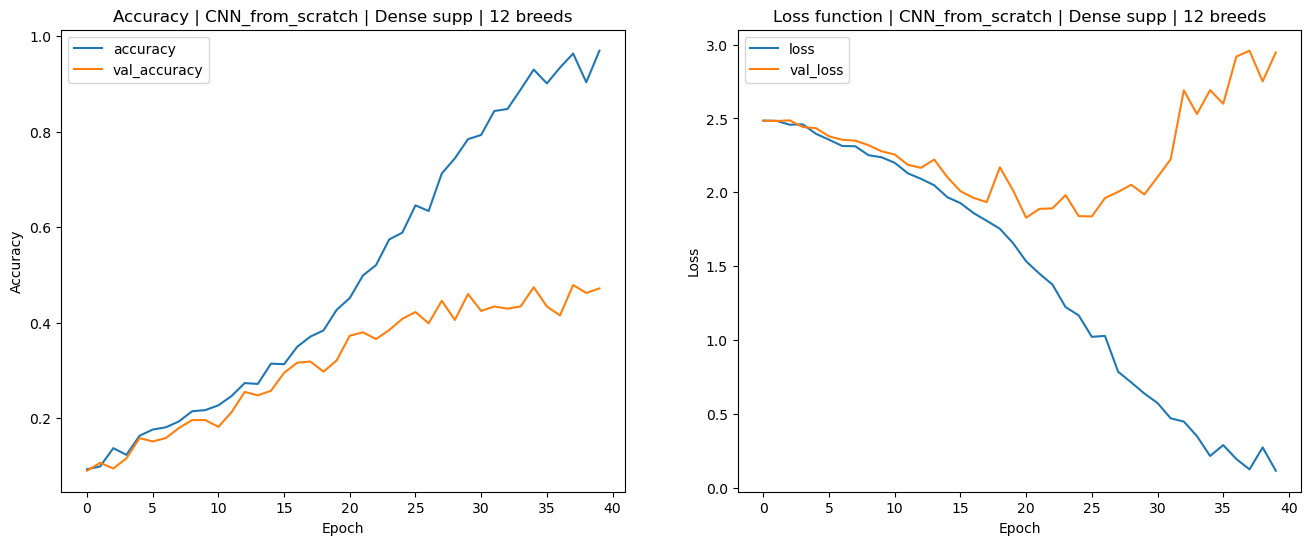

In [9]:
model_dense = get_model(act_function=act)
### Couches de Classification
# Applatissement (transform to vector 1D)
model_dense.add(GlobalAveragePooling2D())
model_dense.add(Dense(256, activation=act))
model_dense.add(Dense(len(train_gen.class_indices), activation='softmax'))

model_dense.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

history_dense = model_dense.fit(train_gen, validation_data=val_gen, epochs=epochs, verbose=verbose)

title = "Dense supp"
test_accuracy[title] = model_dense.evaluate(test_gen)[1]
plot_effect(history_std, history_dense, title, subtitle)
plot_result_fitting(history_dense, subtitle, title, n_breeds)

## 4-4. Mesure de l'effet de BatchNormalization() - Amélioration de la précision

53/53 [==============================] - 3s 56ms/step - loss: 1.7422 - accuracy: 0.5226


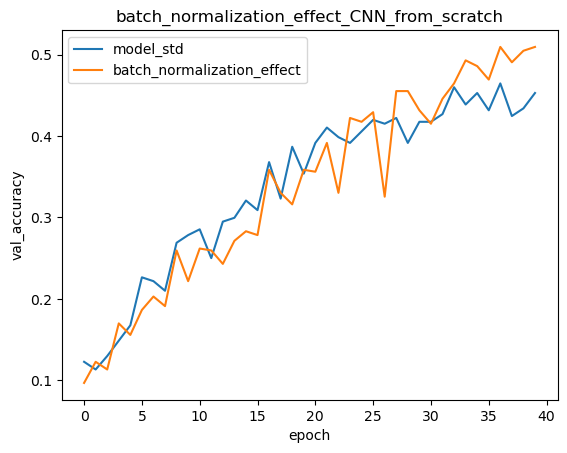

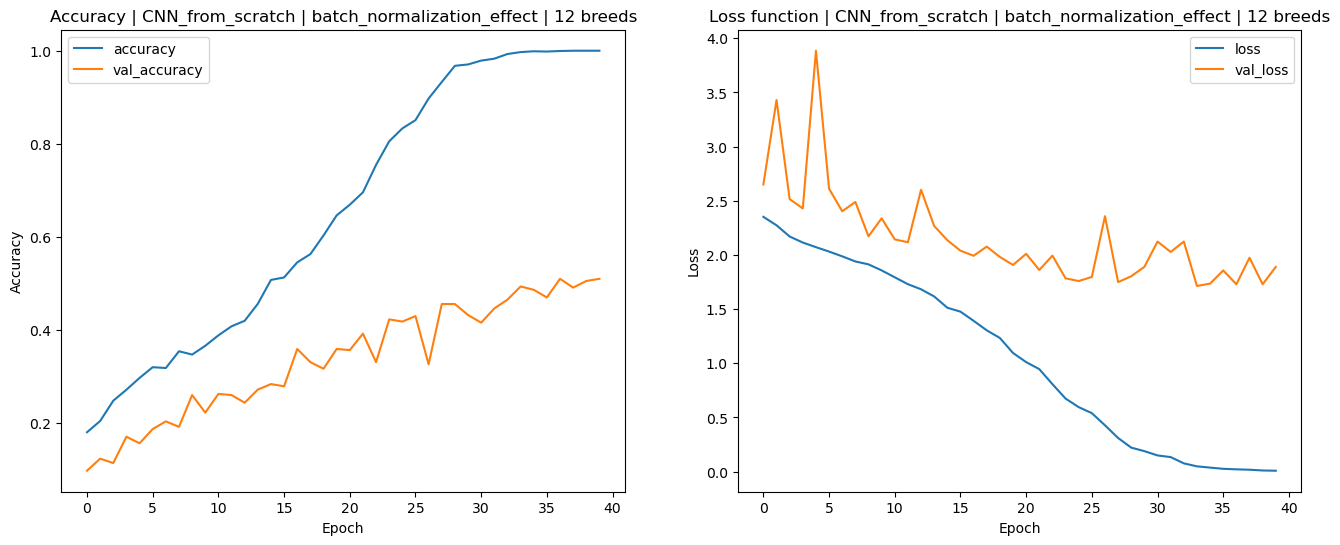

In [10]:
model_batch = get_model(act_function=act)
model_batch.add(BatchNormalization())

### Couches de Classification
# Applatissement (transform to vector 1D)
model_batch.add(GlobalAveragePooling2D())
model_batch.add(Dense(len(train_gen.class_indices), activation='softmax'))

# Complitation
model_batch.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

# Mesure des effets de la couche
history_batch = model_batch.fit(train_gen, validation_data=val_gen, epochs=epochs, verbose=verbose)

title = "batch_normalization_effect"
test_accuracy[title] = model_batch.evaluate(test_gen)[1]
plot_effect(history_std, history_batch, title, subtitle)
plot_result_fitting(history_batch, subtitle, title, n_breeds)

## 4-5. Mesure de l'effet de DropOut() - Régulation du surapprentissage

Test de la valeur 0.2 en cours ...
53/53 [==============================] - 3s 48ms/step - loss: 2.5977 - accuracy: 0.4358


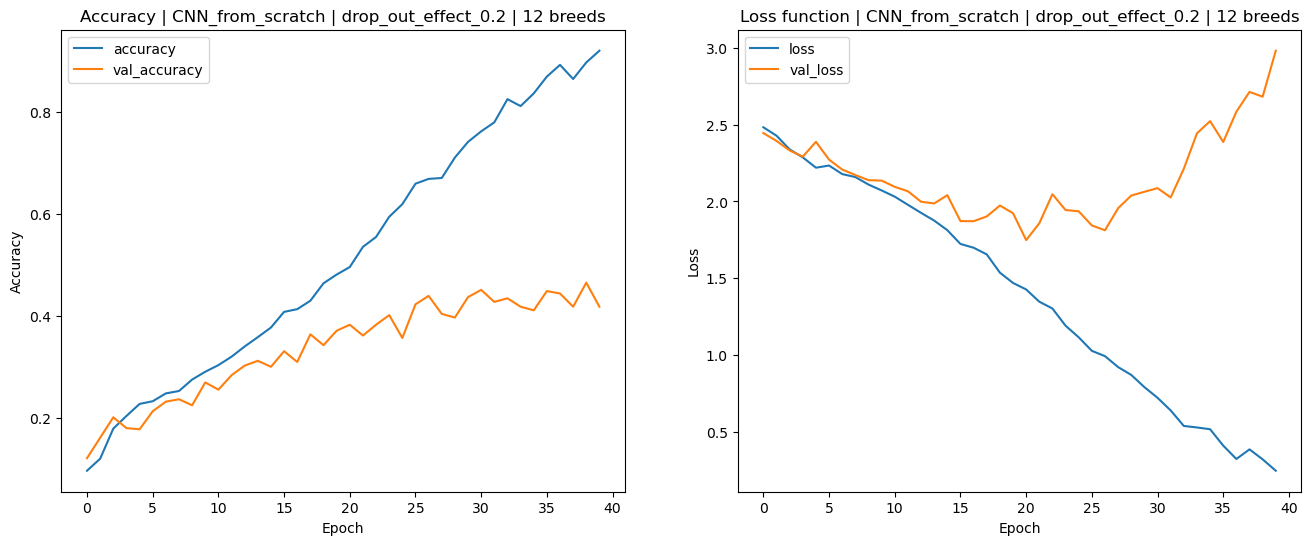

Test de la valeur 0.5 en cours ...
53/53 [==============================] - 2s 45ms/step - loss: 2.3873 - accuracy: 0.4358


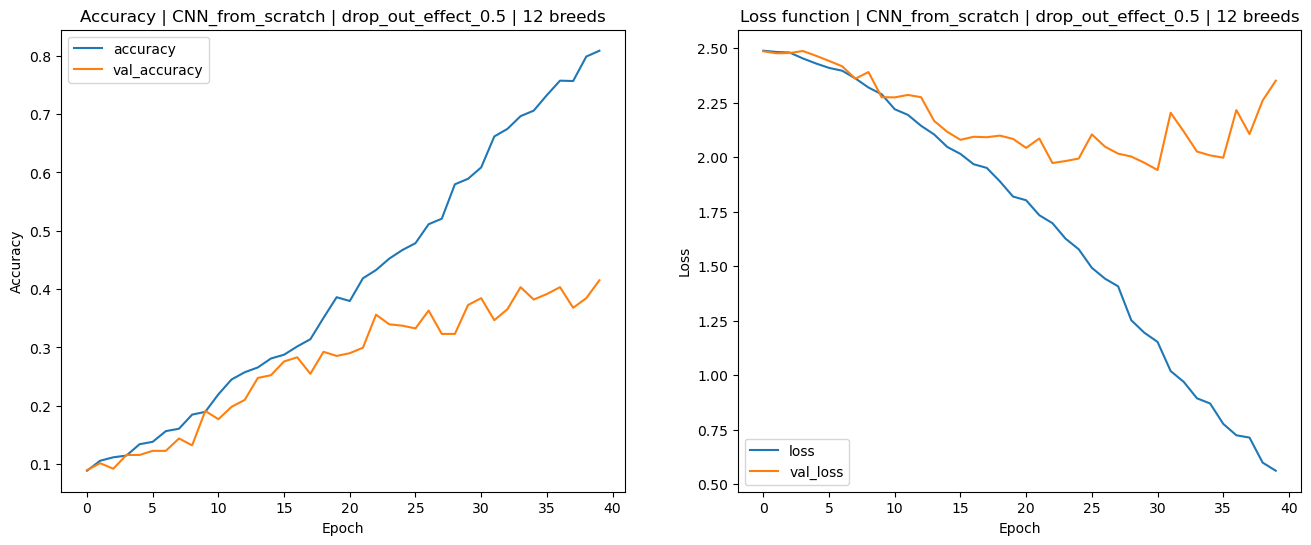

In [11]:
# Je teste 2 valeurs de dropout
value_lst = [0.2, 0.5]

for value in value_lst:
    print(f"Test de la valeur {value} en cours ...")
    
    model_dropout = get_model(act_function=act)
    model_dropout.add(Dropout(value))

    ### Couches de Classification
    # Applatissement (transform to vector 1D)
    model_dropout.add(GlobalAveragePooling2D())
    model_dropout.add(Dense(len(train_gen.class_indices), activation='softmax'))
    
    # Compilation
    model_dropout.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

    # Mesure des effets de la couche
    history_dropout = model_dropout.fit(train_gen, validation_data=val_gen, epochs=epochs, verbose=verbose)

    title = "drop_out_effect_" + str(value)
    test_accuracy[title] = model_dropout.evaluate(test_gen)[1]
    plot_result_fitting(history_dropout, subtitle, title, n_breeds)

## 4-6. Mesure de l'effet de la data augmentation

53/53 [==============================] - 2s 47ms/step - loss: 1.7596 - accuracy: 0.4038


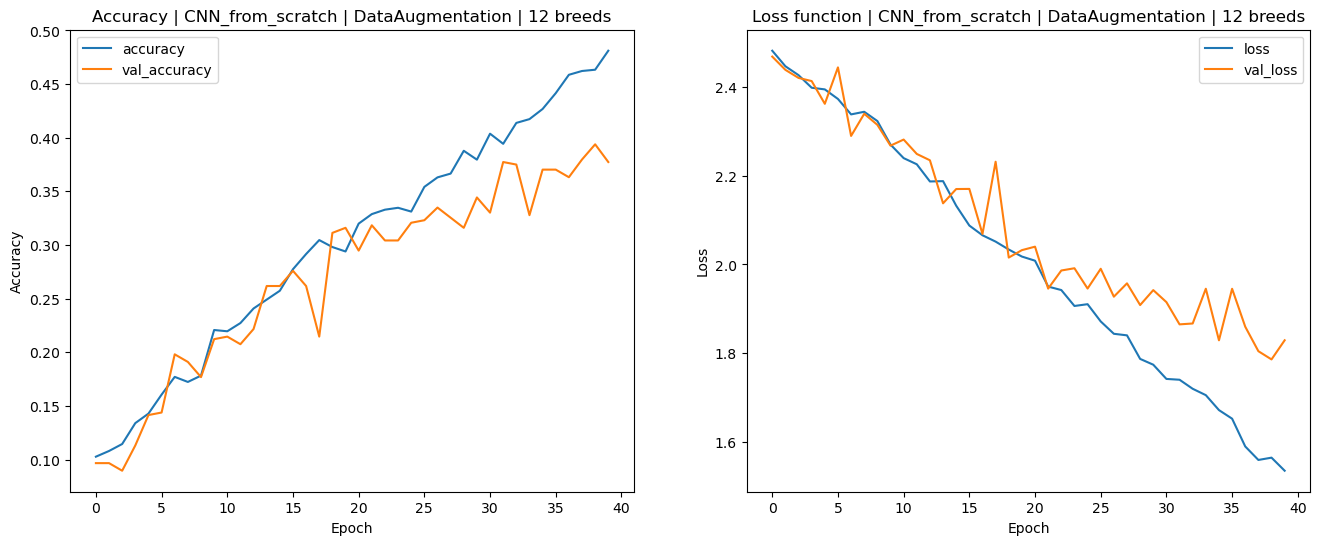

In [12]:
model_aug = get_model(act_function=act)

### Couches de Classification
# Applatissement (transform to vector 1D)
model_aug.add(GlobalAveragePooling2D())
model_aug.add(Dense(len(train_gen.class_indices), activation='softmax'))

model_aug.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
history_aug = model_aug.fit(train_gen_data_aug, validation_data=val_gen, epochs=epochs, verbose=verbose)

title = "DataAugmentation"
test_accuracy[title] = model_aug.evaluate(test_gen)[1]
plot_result_fitting(history_aug, subtitle, title, n_breeds)

## 4-7. Evaluation des tests

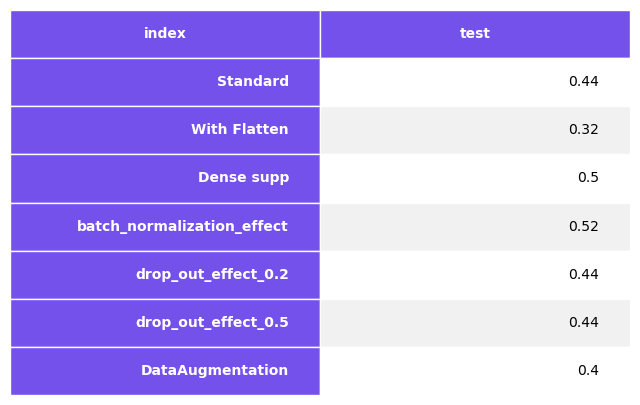

In [13]:
results = pd.DataFrame.from_dict(test_accuracy, orient='index').reset_index().rename(columns={0 : 'test'})
export_png_table(round(results, 2), col_width=4, filename='./cnn_from_scratch_results_' + str(n_breeds) + '_breeds.png')

---
# 5. Entrainement complet sur 12 races | Modèle optimisé

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 28, 28, 128)     

None

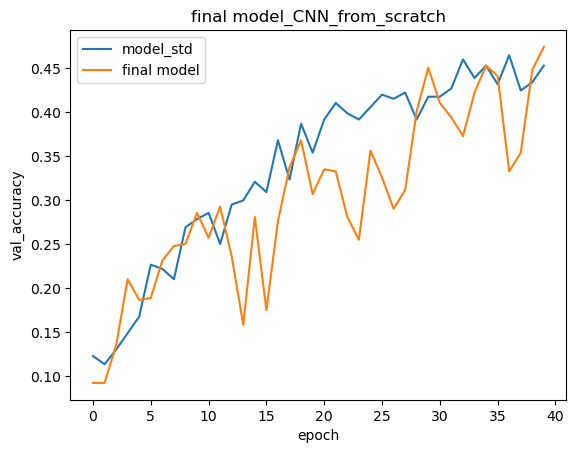

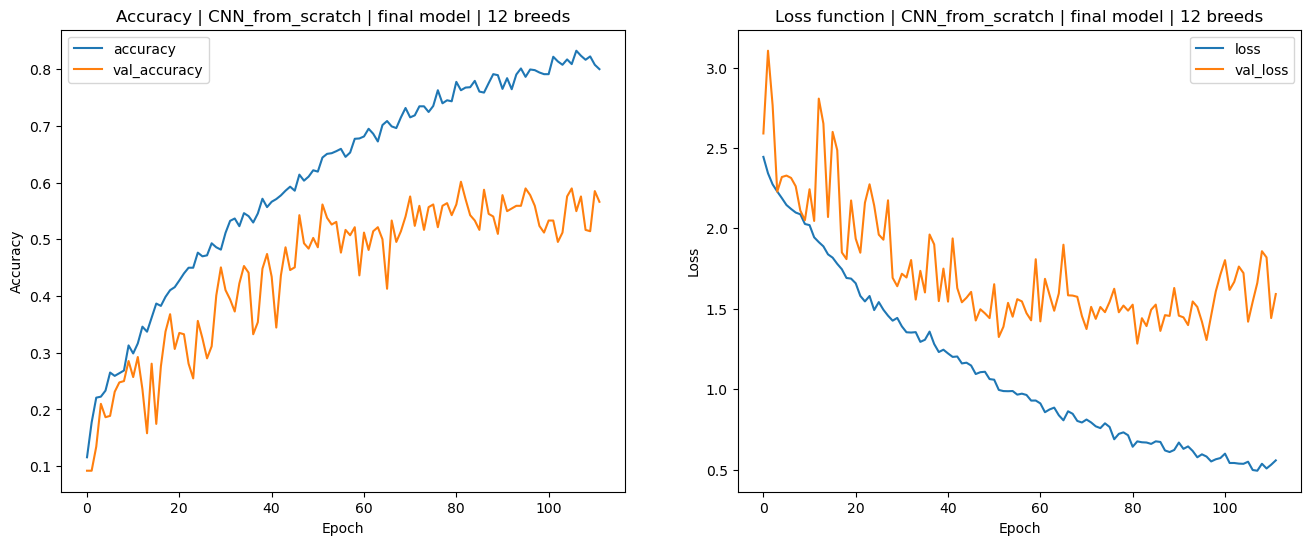

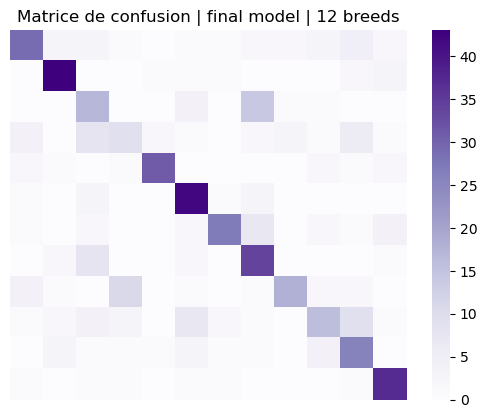

In [14]:
model_final = get_model(act_function=act)
model_final.add(Dropout(0.5))
model_final.add(BatchNormalization())

### Couches de Classification
model_final.add(GlobalAveragePooling2D())
model_final.add(Dense(256, activation=act))
model_final.add(Dense(len(train_gen.class_indices), activation='softmax'))

display(model_final.summary())

# Compliation
model_final.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping_monitor = EarlyStopping(patience=30)
history_final = model_final.fit(train_gen_data_aug, validation_data=val_gen, epochs=500, verbose=verbose, callbacks=[early_stopping_monitor])

title = "final model"
plot_effect(history_std, history_final, title, subtitle)
plot_result_fitting(history_final, subtitle, title, n_breeds)
plot_confusion_matrix(model_final, title, n_breeds)

In [15]:
model_final.evaluate(test_gen)

53/53 [==============================] - 3s 53ms/step - loss: 1.2432 - accuracy: 0.6208


[1.2431700229644775, 0.6207547187805176]